# Introduction :

This notebook presents a complete Regression Model  pipeline applied to a real-world dataset which is **California Housing Dataset**. After selecting and understanding the dataset through **Exploratory Data Analysis (EDA)**, we implement and evaluate several regression models, including **Linear Regression**, **Ridge Regression**, **Lasso Regression**, **Regression Trees**, **Random Forests**, and **XGBoost**. The objective is to compare the predictive performance of these models and understand how regularization and ensemble techniques help improve generalization.

We perform **feature engineering**, **data preprocessing**, and **hyperparameter tuning** using methods such as **K-Fold Cross-Validation**. Each model is assessed using key metrics like **RSS**, **MSE**, **R²**, and **Adjusted R²** on both training and testing sets. Finally, we visualize the actual vs. predicted values and interpret the model coefficients and feature importances to derive meaningful insights. This notebook serves as a comprehensive application of the concepts of Regression Models, integrating theory with hands-on coding.


## Import Libraries & Load California Housing Dataset

- Imported essential Python libraries for **data manipulation**, **visualization**, **model evaluation**, and **machine learning**.  
- Loaded the **California Housing Dataset** from **sklearn.datasets**.  
- Extracted the target variable **MedHouseVal** as the response.  
- Created feature matrix **x** and stored feature names in the **predictors** list.  
- Combined features and response into a new DataFrame called **data** for further processing.  

**Objective**: Prepare and structure the dataset for regression modeling tasks (**OLS**, **Ridge**, **Lasso**,**Regression Tree**,**Random Forest**,**XGBoost**.).


In [26]:
# Import Important  libraries for All models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
import random


# Load the dataset
Housing = fetch_california_housing(as_frame=True)
Housing=Housing.frame
response='MedHouseVal'
# Process the Data for all model
x=Housing.drop('MedHouseVal',axis=1)

x_name=x.columns.tolist()

y=Housing['MedHouseVal']
predictors=x.columns.tolist()
data = pd.concat([x, pd.Series(y, name="response")],axis=1)



## Data Cleaning and Exploratory Data Analysis (EDA)

This cell defines a reusable function **EDA_processing()** that performs key **exploratory data analysis** and **data preprocessing** steps. The main objective of this function is to clean the dataset and give an overview of its structure before modeling.

- It displays basic information like data shape, column types, and summary statistics.
- It checks for **missing values** and fills:
  - numeric columns with their **mean**
  - categorical columns with their **mode**
- Categorical features are converted to numeric using **one-hot encoding**, and boolean columns are converted to integers.
- The function then computes the **Pearson correlation matrix manually** to understand relationships between variables.
- A **correlation heatmap** is plotted for visual insights.
- Finally, it prints the variables that are most correlated with the **target (response)** and lists all **predictor variables**.

This step is essential for understanding the dataset and preparing it for regression and machine learning models.


In [27]:
def EDA_processing(df,response):
    # Drop unnecessary index column if present
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)

    # Display basic info
    print("\nDataset Overview")
    print(df.head())
    print(f"Shape: {df.shape}")
    print("\nColumn Info")
    print(df.info())
    print("\nSummary Statistics")
    print(df.describe())

    # Check and handle missing values
    print("\nMissing Values")
    print(df.isnull().sum())

    # Fill numeric columns with mean
    df.fillna(df.mean(numeric_only=True), inplace=True)

    # Fill categorical columns with mode
    for col in df.select_dtypes(include='object'):
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)

    # Confirm no missing values remain
    print("\nAfter Handling Missing Values")
    print(df.isnull().sum())

    # Encode categorical variables
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # Convert boolean columns to integers
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)

    # Manually compute Pearson correlation matrix
    features = df.columns
    correlation_matrix = pd.DataFrame(index=features, columns=features)

    for i in features:
        for j in features:
            xi = df[i] - df[i].mean()
            xj = df[j] - df[j].mean()
            numerator = np.sum(xi * xj)
            denominator = np.sqrt(np.sum(xi ** 2)) * np.sqrt(np.sum(xj ** 2))
            correlation_matrix.loc[i, j] = numerator / denominator

    # Convert to float for heatmap
    correlation_matrix = correlation_matrix.astype(float)

    # Plot heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix ", fontsize=16)
    plt.show()

    # Correlation with target variable (response)
    print("\nCorrelation with Target (response)")
    Salary_corr = correlation_matrix[response].sort_values(ascending=False)
    print(Salary_corr)

    # Separate response and predictor variables
    responses = response
    predictors = [col for col in df.columns if col != response]
    print(f"\nResponse Variable: {responses}")
    print(f"Predictor Variables ({len(predictors)}): {predictors}")


## Helper Functions for Tree Evaluation and Metrics

This section defines all the **helper functions** needed for evaluating the performance of **Regression Tree models** and calculating **error metrics**.

- **RSS (Residual Sum of Squares)** and **MSE (Mean Squared Error)** are used to measure the prediction error.
- The **R² score** helps determine the proportion of variance in the response variable that is predictable from the features.
- **Adjusted R²** adjusts the R² score for the number of predictors to avoid overfitting.
- A set of functions are also defined specifically for **tree evaluation**:
  - **predict_tree()** is used to recursively predict an individual row by traversing the tree.
  - **batch_predict()** applies tree prediction across an entire dataset using vectorized operations for better performance.
  - **compute_tree_rss()** computes the total RSS error of predictions from a regression tree.
  - **count_leaves()** and **get_tree_depth()** measure the structure of the tree (leaf count and depth).
  - **count_internal_nodes()** counts the internal decision nodes in the tree.
  - **compute_cost_complexity()** calculates the cost-complexity metric used for tree pruning, combining RSS with a penalty for the number of leaves.

These functions are essential for **evaluating tree accuracy**, **performing pruning**, and understanding the complexity and structure of the decision tree.


In [28]:
# All Helper Functions for Metric Evaluation and All Regression Tree
def compute_rss(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

def compute_mse(rss,n):
    return rss/n

def r2_score(y_true, y_pred):
    RSS = np.sum((y_true - y_pred) ** 2)
    TSS = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - RSS / TSS

def adjusted_r2_score(y_true, y_pred, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    return 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

## Compute the prediction of tree
def predict_tree(tree, row):
    if tree["type"] == "leaf":
        return tree["prediction"]
    if row[tree["feature"]] < tree["split_val"]:
        return predict_tree(tree["left"], row)
    else:
        return predict_tree(tree["right"], row)
    
# Calculate Prediction of tree using numpy so that its evaluation more faster
def batch_predict(tree, data):
    return np.array([predict_tree(tree, row) for _, row in data.iterrows()])
# Compute Tree RSS
def compute_tree_rss(tree, data):
    preds = batch_predict(tree, data)
    return compute_rss(data["response"].values, preds)
# Count the tree leaves
def count_leaves(tree):
    if tree["type"] == "leaf":
        return 1
    return count_leaves(tree["left"]) + count_leaves(tree["right"])
# Compute tree depth
def get_tree_depth(tree):
    if tree["type"] == "leaf":
        return 0
    return 1 + max(get_tree_depth(tree["left"]), get_tree_depth(tree["right"]))

# Count internal nodes
def count_internal_nodes(tree):
    if tree["type"] == "leaf":
        return 0
    return 1 + count_internal_nodes(tree["left"]) + count_internal_nodes(tree["right"])

# Compute Cost Complexity of the Tree
def compute_cost_complexity(tree, alpha, data):
    rss = compute_tree_rss(tree, data)
    leaves = count_leaves(tree)
    return rss + alpha * leaves



## Helper Function for Visualizing Predictions

This function **plot_predictions_vs_actuals()** is used to visually compare the **actual** and **predicted** response values from any regression model.

- It creates a **scatter plot** with:
  - Actual values on the x-axis.
  - Predicted values on the y-axis.
- A red dashed line represents the **ideal prediction line**, where predicted = actual.
- This plot helps assess how well the model is performing. Points closer to the diagonal line indicate more accurate predictions.
- The function is generic and can be reused across models like **OLS**, **Ridge**, **Lasso**, or **Tree-based models** for visual evaluation.


In [29]:
# Helper Function for Plotting 
def plot_predictions_vs_actuals(y_true, y_pred, title="Predicted vs Actual Values"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, color='blue', s=50, edgecolor='black')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Prediction')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Linear Regression Model - Implementation and Evaluation

This section implements and evaluates a **Linear Regression model** using the **normal equation** approach. The goal is to estimate the regression coefficients and assess the model's performance using common error metrics.

- **linear_regression_fit()**:  
  Uses the **normal equation** formula to compute the best-fit coefficients for a linear regression model. It augments the feature matrix with a column of ones to account for the **intercept term**, then solves the equation  
  **β = (XᵀX)⁻¹Xᵀy**.

- **linear_regression_predict()**:  
  Predicts the output values using the learned coefficients by computing the dot product of the input features with the coefficients.

- **evaluate_linear_regression()**:  
  This function performs the full modeling pipeline:
  - Splits the data into **training and testing sets** (80/20 split).
  - Fits the linear regression model on the training data.
  - Predicts on both training and test sets.
  - Prints the estimated **intercept** and **coefficients** for each predictor.
  - Visualizes predicted vs. actual values for the test set using a scatter plot.
  - Computes and displays key evaluation metrics:
    - **RSS (Residual Sum of Squares)**
    - **MSE (Mean Squared Error)**
    - **R² Score**

These steps provide a baseline regression model to compare against more complex methods like regularized regression or decision trees.


In [30]:
def linear_regression_fit(x,y) :
    # Forming X Matrix
    X=np.array(x)
    X=np.hstack((np.ones((X.shape[0], 1)), X))
    # Use Normal Equation to fit the model 
    b=np.linalg.inv(X.T@X)@X.T@y
    return b
def linear_regression_predict(x,b):
    X=np.array(x)
    X=np.hstack((np.ones((X.shape[0], 1)), X))
    y_pred=X@b
    return y_pred

def evaluate_linear_regression(x,y,predictors):
    # Train/Test Split for the better modal evaluation 
    train_x, test_x ,train_y,test_y= train_test_split(x,y, test_size=0.2, random_state=42)
    b=linear_regression_fit(train_x,train_y)
    y_train_pred=linear_regression_predict(train_x,b)
    y_test_pred = linear_regression_predict(test_x,b)
    
    print("Estimated Coefficients :")
    for i in range(len(b)):
        if i==0:
            print(f"Intercept : {b[i]:.4f}")
        else :
            print(f"Coefficient for {predictors[i-1]} : {b[i]:.4f}")
    # Plotting Between Test Actual vs Test Predicted

    plot_predictions_vs_actuals(test_y,y_test_pred,title="Linear Regression (Predicted vs Actual)")

    # Metric Evaluation
    train_rss=compute_rss(train_y,y_train_pred)
    train_mse=compute_mse(train_rss,len(train_y))
    test_rss=compute_rss(test_y,y_test_pred)
    test_mse=compute_mse(test_rss,len(test_y))
    train_r2=r2_score(train_y,y_train_pred)
    test_r2=r2_score(test_y,y_test_pred)
    # Print All Metric Evaluation
    print(f"Train RSS : {train_rss :.4f}")
    print(f"Test RSS :{test_rss :.4f}")
    print(f"Train MSE :{train_mse :.4f}")
    print(f"Test MSE :{test_mse :.4f}")
    print(f"Train R^2 :{train_r2 :.2f}")
    print(f"Test R^2 :{test_r2 :.2f}")


## Ridge Regression - Implementation and Evaluation

This section focuses on implementing **Ridge Regression**, which introduces **L2 regularization** to the traditional linear regression model. Ridge helps reduce overfitting by penalizing large coefficients.

### Key Functions:

- **ridge_beta()**:  
  Calculates the Ridge Regression coefficients using the formula:  
  **β = (XᵀX + λI)⁻¹Xᵀy**,  
  where λ is the regularization parameter and I is the identity matrix. This helps shrink coefficients and manage multicollinearity.

- **best_lambda()**:  
  Finds the best λ (regularization strength) using **K-Fold Cross-Validation** over a predefined range of λ values.  
  For each λ:
  - The data is split into training and validation folds.
  - The model is trained and tested.
  - The average validation **MSE** is calculated.
  - The λ with the **lowest average MSE** is selected as the optimal value.

- **predict_ridge()**:  
  Predicts the response values using the final estimated ridge coefficients. It includes an intercept term by augmenting the feature matrix.

- **evaluate_ridge_regression()**:  
  This is the main function that executes the full Ridge Regression workflow:
  - Splits the data into training and testing sets.
  - Standardizes the features to ensure that all variables are on the same scale.
  - Determines the best λ using cross-validation.
  - Fits the final Ridge model on the standardized training data.
  - Rescales the coefficients to match the original scale of the features.
  - Separately computes the intercept.
  - Predicts on both training and testing data.
  - Displays the estimated **intercept** and **coefficients** for each feature.
  - Plots **predicted vs. actual values** on the test set to visualize model accuracy.

### Evaluation Metrics:
- Computes and displays the following for both training and testing sets:
  - **RSS (Residual Sum of Squares)**
  - **MSE (Mean Squared Error)**
  - **R² Score**
  - **Adjusted R² Score**

These metrics help determine how well the Ridge Regression model fits the data and how it generalizes to unseen data. Ridge often improves performance when multicollinearity or overfitting is present in OLS models.


In [31]:
# Making a Function Which Calculate The Ridge Coefficients with lambda values
def ridge_beta(X, y, lam):
    n_features = X.shape[1]
    I = np.eye(n_features)
    XT_X = X.T @ X
    XT_y = X.T @ y
    beta_ridge = np.linalg.solve(XT_X + lam * I, XT_y)  # Better than inv()
    return beta_ridge

# Finding Best Lambda Using Grid Search Using k Fold
def best_lambda(x,y,lambda_values=np.logspace(-5,5,50),k=10):
    avg_cv_errors=[]
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for lam in lambda_values:
        cv_errors = []
        for train_idx, val_idx in kf.split(x):
            X_train, X_val = x.iloc[train_idx], x.iloc[val_idx]

            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


            beta_ridge = ridge_beta(X_train, y_train, lam)
            y_pred = X_val @ beta_ridge
            mse = mean_squared_error(y_val, y_pred)
            cv_errors.append(mse)
        avg_cv_errors.append(np.mean(cv_errors))
    # Select best lambda
    best_lambda = lambda_values[np.argmin(avg_cv_errors)]
    return best_lambda

def predict_ridge(x,b):
    X=np.column_stack((np.ones(x.shape[0]), x))
    y_pred=X@b
    return y_pred

# Evaluate Ridge Regression
def evaluate_ridge_regression(x,y,predictors):
    train_x, test_x ,train_y,test_y= train_test_split(x,y, test_size=0.2, random_state=42)
    # Standardise the train Data
    x_mean=np.mean(train_x,axis=0)
    x_std=np.std(train_x,axis=0)
    x_standardized = (train_x - x_mean) / x_std
    best_lam=best_lambda(x_standardized,train_y)
    final_beta=ridge_beta(x_standardized,train_y,best_lam)

    # Rescale the beta coefficietns
    final_beta_ridge=final_beta/x_std
    # Compute intercept (β₀) separately (from original data)
    beta_0 = np.mean(train_y) - np.dot(final_beta_ridge, x_mean)

    # Combine intercept and coefficients
    beta_full = np.insert(final_beta_ridge, 0, beta_0)
    y_train_pred=predict_ridge(train_x,beta_full)
    y_test_pred=predict_ridge(test_x,beta_full)

    # Display the coefficients
    print("Ridge Regression Coefficients:")
    for i, coef in enumerate(beta_full):
        if i == 0:
            print(f"Intercept (β₀): {coef:.4f}")
        else:
            print(f"Coefficient for {predictors[i-1]}: {coef:.4f}")
    # Plotting Between Test Actual vs Test Predicted

    plot_predictions_vs_actuals(test_y,y_test_pred,title="Ridge Regression (Predicted vs Actual)")
    p=x.shape[1]
    # Metric Evaluation
    train_rss=compute_rss(train_y,y_train_pred)
    train_mse=compute_mse(train_rss,len(train_y))
    test_rss=compute_rss(test_y,y_test_pred)
    test_mse=compute_mse(test_rss,len(test_y))
    train_r2=r2_score(train_y,y_train_pred)
    test_r2=r2_score(test_y,y_test_pred)
    train_adj_r2=adjusted_r2_score(train_y,y_train_pred,p)
    test_adj_r2=adjusted_r2_score(test_y,y_test_pred,p)
    # Print All Metric Evaluation
    print(f"Train RSS : {train_rss :.4f}")
    print(f"Test RSS :{test_rss :.4f}")
    print(f"Train MSE :{train_mse :.4f}")
    print(f"Test MSE :{test_mse :.4f}")
    print(f"Train R^2 :{train_r2 :.2f}")
    print(f"Test R^2 :{test_r2 :.2f}")
    print(f"Train Adjusted R^2 :{train_adj_r2 :.2f}")
    print(f"Test Adjusted R^2 :{test_adj_r2 :.2f}")


## Lasso Regression Implementation and Evaluation

This section implements **Lasso Regression** from scratch using the **Coordinate Descent algorithm**. The goal of Lasso is not just to minimize error but also to perform **feature selection** by shrinking some coefficients exactly to zero.

The overall workflow consists of the following key steps:

- **Soft Thresholding Function**: A helper function used in coordinate descent to apply the Lasso penalty, effectively shrinking coefficients based on the regularization strength (lambda).

- **Lasso Coordinate Descent Algorithm**: Iteratively updates each coefficient while keeping others fixed. It calculates the partial residual and applies soft thresholding to update the value of each coefficient. This continues until the change in coefficients is below a set threshold or a maximum number of iterations is reached.

- **Best Lambda Selection Using K-Fold Cross Validation**: A range of lambda values (regularization strengths) are tested using **10-fold cross-validation**. For each lambda:
  - The model is trained on 9 folds and validated on 1.
  - The **mean squared error (MSE)** is recorded.
  - The average MSE across all folds is used to identify the best lambda value.

- **Model Training and Prediction**:
  - The training features are **standardized** (zero mean, unit variance), and the target variable is **centered** to improve convergence.
  - The final coefficients are obtained using the best lambda.
  - The coefficients are rescaled back to the original feature scale and the **intercept** is computed manually.
  - Predictions are made for both training and testing sets.

- **Coefficient Output**:
  - The model prints each coefficient including the intercept.
  - Due to the Lasso penalty, many coefficients may become **exactly zero**, showing that those features were dropped from the model.

- **Prediction Plot**:
  - A scatter plot is created comparing the actual vs predicted values on the test set.
  - This helps visualize how well the model fits the data.

- **Evaluation Metrics**:
  - **RSS**, **MSE**, **R²**, and **Adjusted R²** are computed for both training and testing sets.
  - These metrics help quantify the model’s performance and generalization capability.

Lasso is particularly effective in high-dimensional settings or when we believe that only a subset of features are truly relevant. Its ability to zero out less important features makes it useful for **feature selection and interpretation**.


In [32]:
# Now i am going to build lasso regression 
def soft_threshold(rho, lam):
    if rho < -lam:
        return rho + lam
    elif rho > lam:
        return rho - lam
    else:
        return 0.0

def lasso_coordinate_descent(X, y, lam, tol=1e-4, max_iter=1000):
    n=X.shape[0]
    p = X.shape[1]
    beta = np.zeros(p)
    
    # Coordinate Descent Algorithm
    for _ in range(max_iter):
        beta_old = beta.copy()
        for j in range(p):
            X_j = X.iloc[:, j].values
            y_pred = X @ beta
            residual = y - y_pred + beta[j] * X_j # partial residual
            rho_j = np.dot(X_j, residual)
            beta[j] = soft_threshold(rho_j / n, lam) / (np.dot(X_j, X_j) / n)
        if np.sum(np.abs(beta - beta_old)) < tol:
            break
    return beta

def best_lambda_lasso(x,y,lambda_values=np.logspace(-5,5,50),k=10):
    avg_cv_errors=[]
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for lam in lambda_values:
        cv_errors = []
        for train_idx, val_idx in kf.split(x):
            X_train, X_val = x.iloc[train_idx], x.iloc[val_idx]

            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


            beta_lasso = lasso_coordinate_descent(X_train, y_train, lam)
            y_pred = X_val @ beta_lasso
            mse = mean_squared_error(y_val, y_pred)
            cv_errors.append(mse)
        avg_cv_errors.append(np.mean(cv_errors))
    # Select best lambda
    best_lambda = lambda_values[np.argmin(avg_cv_errors)]
    return best_lambda
# Making a Function for Predictions
def predict_lasso(x,b):
    X=np.column_stack((np.ones(x.shape[0]), x))
    y_pred=X@b
    return y_pred
# Evaluate Lasso Regression
def evaluate_lasso_regression(x,y,predictors):
    train_x, test_x ,train_y,test_y= train_test_split(x,y, test_size=0.2, random_state=42)
    # Standardise and Centre the train Data
    x_mean=np.mean(train_x,axis=0)
    x_std=np.std(train_x,axis=0)
    x_standardized = (train_x - x_mean) / x_std
    y_mean=np.mean(train_y)
    y_centre=train_y-y_mean
    best_lam=best_lambda_lasso(x_standardized,y_centre)
    final_beta=lasso_coordinate_descent(x_standardized,y_centre,best_lam)

    # Rescale the beta coefficietns
    final_beta_lasso=final_beta/x_std
    # Compute intercept (β₀) separately (from original data)
    beta_0 = np.mean(train_y) - np.dot(final_beta_lasso, x_mean)

    # Combine intercept and coefficients
    beta_full = np.insert(final_beta_lasso, 0, beta_0)
    y_train_pred=predict_lasso(train_x,beta_full)
    y_test_pred=predict_lasso(test_x,beta_full)

    # Display the coefficients
    print("Lasso Regression Coefficients:")
    for i, coef in enumerate(beta_full):
        if i == 0:
            print(f"Intercept (β₀): {coef:.4f}")
        else:
            print(f"Coefficient for {predictors[i-1]}: {coef:.4f}")
    # Plotting Between Test Actual vs Test Predicted

    plot_predictions_vs_actuals(test_y,y_test_pred,title="Lasso Regression (Predicted vs Actual)")
    p=x.shape[1]
    # Metric Evaluation
    train_rss=compute_rss(train_y,y_train_pred)
    train_mse=compute_mse(train_rss,len(train_y))
    test_rss=compute_rss(test_y,y_test_pred)
    test_mse=compute_mse(test_rss,len(test_y))
    train_r2=r2_score(train_y,y_train_pred)
    test_r2=r2_score(test_y,y_test_pred)
    train_adj_r2=adjusted_r2_score(train_y,y_train_pred,p)
    test_adj_r2=adjusted_r2_score(test_y,y_test_pred,p)
    # Print All Metric Evaluation
    print(f"Train RSS : {train_rss :.4f}")
    print(f"Test RSS :{test_rss :.4f}")
    print(f"Train MSE :{train_mse :.4f}")
    print(f"Test MSE :{test_mse :.4f}")
    print(f"Train R^2 :{train_r2 :.2f}")
    print(f"Test R^2 :{test_r2 :.2f}")
    print(f"Train Adjusted R^2 :{train_adj_r2 :.2f}")
    print(f"Test Adjusted R^2 :{test_adj_r2 :.2f}")


## Regression Tree from Scratch Using Recursive Binary Splitting and Cost-Complexity Pruning :

In this section, we implement a regression tree model entirely from scratch. This includes growing the full tree using recursive binary splitting and then pruning it using cost-complexity pruning to reduce overfitting and improve generalization.

We start with a helper function **find_best_split** that identifies the optimal feature and split value at each node. It tries all unique values (or a random sample if there are too many) for every predictor and selects the split that minimizes the Residual Sum of Squares (RSS).

The **grow_tree** function builds the tree recursively. It continues to split the data until the stopping criteria are met — either the number of samples in a node falls below a minimum threshold or a specified maximum depth is reached. At each step, we store information about the node including whether it's a split or a leaf, the feature used for the split, the split value, and predictions for each region.

Next, we define the **prune_tree** function to reduce the complexity of the full tree. Cost-complexity pruning compares the cost of keeping a subtree (its RSS plus a penalty proportional to the number of leaves) with the cost of collapsing it into a single leaf. If pruning reduces the overall cost, we prune that subtree.

To identify the optimal alpha value (the complexity penalty), we use **cross_validate_pruning**. It performs k-fold cross-validation over a grid of alpha values. For each fold, we grow a full tree on the training subset, prune it for each alpha, and record the validation error. The alpha that gives the lowest average error across folds is selected as the best one.

With the best alpha in hand, we grow and prune the final tree using **final_pruned_tree**.

Finally, the **evaluate_regression_tree** function performs the end-to-end evaluation. It splits the dataset into training and test sets, selects the best alpha, prunes the tree, and then calculates metrics including **RSS, MSE, R² score, tree depth, number of internal nodes, and number of leaves**. A plot of predicted vs actual values on the test set is also displayed to visually assess the performance.

This full pipeline provides an interpretable tree-based regression model, carefully balancing model complexity and performance through custom pruning.

In [33]:
# All Main  Function for Regression Tree
# Now i am going to apply greedy Recursive Binary Split Approach to get full tree 
# This function heps to best split a region this is a helper function we use it in main grow tree function


def find_best_split(data, predictors):
    best_rss = float("inf") # Assign with infinite 
    best_split = None 
    y=data["response"].values
    for feature in predictors: # Checking for all predictors and there best cutpoints
        feature_values = np.sort(np.unique(data[feature].values))
        if len(feature_values) > 1:
            split_candidates = (feature_values[:-1] + feature_values[1:]) / 2
        else:
            continue  # Skip feature with no variation
        if len(split_candidates) > 100:
            split_candidates = np.random.choice(split_candidates, 100, replace=False)
            split_candidates = np.sort(split_candidates)  # Re-sort after sampling
        for s in split_candidates:
            left = data[feature].values< s # select that data where this condition is true
            right = ~left
            if np.sum(left) == 0 or np.sum(right) == 0: # Checking the emptyness of region
                continue
            y_left=y[left]
            y_right=y[right]
            y_left_pred = y_left.mean()
            y_right_pred = y_right.mean()
            rss = compute_rss(y_left, y_left_pred) + compute_rss(y_right, y_right_pred)
            if rss < best_rss:
                best_rss = rss
                best_split = { # Dictionary to store the information 
                    "feature": feature,
                    "split_val": s,
                    "rss": best_rss,
                    "left_mean": y_left_pred,
                    "right_mean": y_right_pred
                }
    return best_split

# This is the main function which calculate the complete grow tree
def grow_tree(data, predictors, min_samples_split=20, depth=0,max_depth=5):
    # Stopping condition
    if len(data) < min_samples_split or depth>=max_depth :
        return {
            "type": "leaf",
            "prediction": data["response"].mean(),
            "samples": len(data),
            "depth": depth
        }

    # Find best split
    best_split = find_best_split(data, predictors)
    if not best_split: # if no best split is possible 
        return {
            "type": "leaf",
            "prediction": data["response"].mean(),
            "samples": len(data),
            "depth": depth
        }
    
    
    # Recursively grow left and right branches
    left_data = data[data[best_split["feature"]] < best_split["split_val"]]
    right_data = data[data[best_split["feature"]] >= best_split["split_val"]]
    return {
        "type": "node",
        "feature": best_split["feature"],
        "split_val": best_split["split_val"],
        "left": grow_tree(left_data, predictors, min_samples_split, depth + 1),
        "right":grow_tree(right_data, predictors, min_samples_split, depth + 1),
        "depth": depth
    }
# Now make a function which prune the cost complexity for give some penality to reduce the varience
# Prune using cost complexity pruning for each alpha 
def prune_tree(tree, data, alpha):
    # Base case: if the node is already a leaf, return as-is
    if tree["type"] == "leaf":
        return tree

    # Split the data according to current node's condition
    left_data = data[data[tree["feature"]] < tree["split_val"]]
    right_data = data[data[tree["feature"]] >= tree["split_val"]]

    # Recursively prune left and right subtrees
    tree["left"] = prune_tree(tree["left"], left_data, alpha)
    tree["right"] = prune_tree(tree["right"], right_data, alpha)

    # Evaluate cost of current subtree
    subtree_rss = compute_tree_rss(tree, data)
    subtree_leaves = count_leaves(tree)
    subtree_cost = subtree_rss + alpha * subtree_leaves

    # Evaluate cost of pruning this node into a single leaf
    leaf_prediction = data["response"].mean()
    leaf_rss = compute_rss(data["response"].values, np.full(len(data), leaf_prediction))
    leaf_cost = leaf_rss + alpha * 1  # 1 leaf node

    # Decide whether to prune this node
    if leaf_cost <= subtree_cost:
        return {
            "type": "leaf",
            "prediction": leaf_prediction,
            "samples": len(data),
            "depth": tree["depth"]
        }
    else:
        return tree

# Evaluate the Tree
def evaluate_tree(tree, val_data):
    
    # Predict using the tree
    y_true = val_data["response"].values
    y_pred = batch_predict(tree, val_data)

    # Compute MSE
    rss = compute_rss(y_true, y_pred)
    mse = compute_mse(rss, len(val_data))
    
    return mse

# Cross-validation for each alpha to find best alpha

def cross_validate_pruning(data, predictors, alphas, k_folds=5, min_samples_split=20, max_depth=5):
    
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    alpha_errors = {alpha: [] for alpha in alphas}
    
    for train_index, val_index in kf.split(data):
        train_data = data.iloc[train_index].reset_index(drop=True)
        val_data = data.iloc[val_index].reset_index(drop=True)
        
        # Build full tree on training data
        full_tree = grow_tree(train_data, predictors, min_samples_split=min_samples_split, max_depth=max_depth)
        
        # Prune and evaluate for each alpha
        for alpha in alphas:
            pruned_tree = prune_tree(full_tree, train_data, alpha)
            mse = evaluate_tree(pruned_tree, val_data)
            alpha_errors[alpha].append(mse)
    
    # Average the errors
    alpha_mse_list = [(alpha, np.mean(mse_list)) for alpha, mse_list in alpha_errors.items()]
    
    # Select best alpha
    best_alpha = min(alpha_mse_list, key=lambda x: x[1])[0]
    
    return best_alpha, alpha_mse_list

# Function to get best subtree after pruning on best alpha
def final_pruned_tree(df, predictors, alpha, min_samples_split=20, max_depth=5):
  
    # Build full tree
    full_tree = grow_tree(df, predictors, min_samples_split=min_samples_split, max_depth=max_depth)

    # Prune it using selected alpha
    pruned_tree = prune_tree(full_tree, df, alpha)
    
    return pruned_tree


def evaluate_regression_tree(data, predictors, alpha_values=np.linspace(0, 10, 21), test_size=0.2, random_state=42, min_samples_split=20,max_depth=8):
    # Train/Test Split
    train_df, test_df = train_test_split(data, test_size=test_size, random_state=random_state)

    # Select best alpha using CV on training data
    best_alpha, alpha_errors = cross_validate_pruning(train_df, predictors, alpha_values, k_folds=5, min_samples_split=min_samples_split,max_depth=max_depth)

    # Train best-pruned tree on training data and get best tree 
    best_tree = final_pruned_tree(train_df, predictors, best_alpha, min_samples_split=min_samples_split,max_depth=max_depth)

    # Step 4: Evaluation
    train_rss = compute_tree_rss(best_tree, train_df)
    test_rss = compute_tree_rss(best_tree, test_df)

    train_mse = train_rss / len(train_df)
    test_mse = test_rss / len(test_df)

    tree_depth = get_tree_depth(best_tree)
    n_leaves = count_leaves(best_tree)
    nodes=count_internal_nodes(best_tree)

    y_test = test_df["response"].values
    test_predictions = test_df.apply(lambda row: predict_tree(best_tree, row), axis=1)
    y_test_pred=test_predictions.values
    test_r2 = r2_score(y_test, y_test_pred)
    # Calculating Train R_2 also 
    y_train = train_df["response"].values
    y_train_pred = train_df.apply(lambda row: predict_tree(best_tree, row), axis=1).values
    train_r2=r2_score(y_train,y_train_pred)
    # Print the results
    print("Final Regression Tree Evaluation")
    print(f"Best alpha (from CV): {best_alpha}")
    print(f"Tree Depth: {tree_depth}")
    print(f"Internal Nodes: {nodes}")
    print(f"Number of Leaves: {n_leaves}")
    print(f"Train RSS: {train_rss:.2f}")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test RSS: {test_rss:.2f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Train R_2 Score: {train_r2:.4f}")
    print(f"Test R_2 Score: {test_r2:.4f}")
    plot_predictions_vs_actuals(y_test,y_test_pred,title="Regression Tree (Predicted vs Actual)")

## Random Forest Implementation & Evaluation Summary

**Step 1: Bootstrap Sampling**
A helper function **bootstrap_sample()** is defined to randomly sample the dataset **with replacement**. This creates diverse training sets for individual trees in the forest, introducing variance and helping generalization.

**Step 2: Training the Random Forest**
The function **train_random_forest()** builds an ensemble of decision trees (a forest). For each tree:

* A **bootstrap sample** of the training data is used.
* A random subset of **features** is selected (**max_features**) to split nodes, reducing correlation among trees.
* The tree is trained using the **grow_tree()** function up to a defined **max_depth**.

Each trained tree is stored with its corresponding features.

**Step 3: Making Predictions**
The function **predict_forest()** averages the predictions from all trees in the forest to produce the final prediction for each observation. This reduces overfitting by aggregating multiple weak learners.

**Step 4: Evaluation**
Using the function **evaluate_random_forest()**:

* The data is split into **training and testing sets**.
* A **Random Forest** is trained using 10 trees, **max_depth = 3**, and **max_features = 4**.
* **Predictions** are made for both train and test sets.
* **Residual Sum of Squares (RSS)**, **Mean Squared Error (MSE)**, and **R² score** are computed.
* A scatter plot is generated comparing predicted vs actual values for the test set.

**Metric Output Includes**:

* Train and Test RSS
* Train and Test MSE
* Train and Test R² score

**Purpose**:
This method leverages **bagging** and **feature randomness** to create a more robust predictive model compared to a single decision tree, especially in reducing overfitting and improving generalization.



In [34]:
# Now i am going to build Randoom Forest
# Bootstrap Sampling the data
def bootstrap_sample(data):
    indices = np.random.randint(0, len(data), len(data))
    return data.iloc[indices].reset_index(drop=True)

# Train Random Forest With Feature Subsampling and Bootstrap
def train_random_forest(data, n_trees=10, max_depth=3, min_samples_split=20, max_features=None):
    forest = []
    for i in range(n_trees):
        sample = bootstrap_sample(data)
        max_features = min(max_features if max_features else int(np.sqrt(len(predictors))), len(predictors))
        subset_features = random.sample(predictors, max_features)
        tree = grow_tree(sample, subset_features, max_depth=max_depth, min_samples_split=min_samples_split)
        forest.append((tree, subset_features))
    return forest

# Make Predictions From all Trees in Forest with Forest

def predict_forest(forest, data):
    preds = []
    for tree, features in forest:
        pred = data.apply(lambda row: predict_tree(tree, row), axis=1)
        preds.append(pred)
    preds = np.array(preds)
    return np.mean(preds, axis=0)

def evaluate_random_forest(data):
    train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
    rf_model = train_random_forest(train_df, n_trees=10, max_depth=3, max_features=4)

    train_preds = predict_forest(rf_model, train_df)
    test_preds = predict_forest(rf_model, test_df)
    y_true=test_df["response"]
    train_rss=compute_rss(train_df['response'],train_preds)
    train_mse=train_rss/len(train_df)
    test_rss=compute_rss(test_df['response'],test_preds)
    test_mse=test_rss/len(test_df)
    plot_predictions_vs_actuals(y_true,test_preds,title="Random Forest (Predicted vs Actual)")
    train_r2 = r2_score(train_df["response"].values, train_preds)
    test_r2 = r2_score(test_df["response"].values, test_preds)

    print("Random Forest Metric Evaluation")
    print(f"Train_RSS :{train_rss:.4f}")
    print(f"Test_RSS :{test_rss :.4f}")
    print(f"Train MSE :{train_mse :.4f}")
    print(f"Test MSE :{test_mse :.4f}")
    print(f"Train R^2: {train_r2:.4f}")
    print(f"Test R^2: {test_r2:.4f}")

## XGBoost Implementation And Evaluation :

**1. Fitting the Boosting Model**
- The function **xgboost_fit** builds an additive model using gradient boosting principles:
  - **Initial Residuals**: Start with the actual response values as the residuals.
  - For each boosting round (**n_estimators**):
    - A shallow regression tree is fitted to the current residuals (errors from the previous model).
    - Residuals are updated by subtracting a scaled version of the prediction (**learning_rate × prediction**).
    - The fitted tree is appended to the list of models.
  - This sequential process reduces errors step-by-step and builds a strong predictor from weak learners (shallow trees).

**2. Predicting With Boosting Model**
- The function **xgboost_predict** accumulates predictions from all weak learners:
  - For each tree in the model:
    - Predict on the input data.
    - Add the scaled prediction to the running total.
  - The final prediction is the sum of all these scaled predictions.

**3. Evaluating the Boosting Model**
- The function **evaluate_XGBoost** performs training, prediction, and evaluation:
  - Splits the dataset into training and testing sets.
  - Trains the boosting model on training data using the defined number of estimators, max depth, and learning rate.
  - Makes predictions for both training and testing data.
  - Calculates and prints metrics:
    - **Train RSS**: Residual Sum of Squares on training data.
    - **Test RSS**: Residual Sum of Squares on test data.
    - **Train MSE**: Mean Squared Error on training data.
    - **Test MSE**: Mean Squared Error on test data.
    - **Train R²**: Coefficient of determination on training data.
    - **Test R²**: Coefficient of determination on test data.
  - Plots predicted vs actual values for the test set using **plot_predictions_vs_actuals**.

**Summary**
- This boosting approach reduces bias by iteratively correcting errors from previous models.
- Each tree attempts to correct the mistakes of the ensemble so far.
- The learning rate controls how much each tree contributes, preventing overfitting.
- XGBoost, built this way from scratch, is powerful for regression tasks when properly tuned.


In [35]:
# This Function Creaate all tress in Boosting 
def xgboost_fit(data, predictors, response_col, n_estimators=100, learning_rate=0.1, max_depth=2, min_samples_split=20):
    models = []       # Stores all fitted trees
    residuals=data[response_col]
    for i in range(n_estimators):
        # Create new dataset with residuals as the new target
        training_data = data[predictors].copy()
        training_data["response"] = residuals ## add a fake columns for predicting a tree 

        # Fit a shallow regression tree to residuals
        tree = grow_tree(training_data,predictors, min_samples_split=min_samples_split, depth=0, max_depth=max_depth)
        
        # Predict residuals
        pred = training_data.apply(lambda row: predict_tree(tree, row), axis=1)
        
        # Update the residuals
        residuals = residuals- learning_rate * pred
        models.append(tree)
    return models

# This function predict the final result of model
def xgboost_predict(models, data, learning_rate=0.1):
    total_pred = np.zeros(len(data))
    for tree in models:
        pred = data.apply(lambda row: predict_tree(tree, row), axis=1)
        total_pred += learning_rate * pred
    return total_pred

def evaluate_XGBoost(data):
    train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
    response_col="response"
    # Train XGBoost model
    xgb_model = xgboost_fit(train_df, predictors,response_col, n_estimators=100, learning_rate=0.1, max_depth=1)

    # Predict
    train_preds = xgboost_predict(xgb_model, train_df, learning_rate=0.1)
    test_preds_xg = xgboost_predict(xgb_model, test_df, learning_rate=0.1)
    y_true=test_df["response"]
    train_rss=compute_rss(train_df['response'],train_preds)
    train_mse=train_rss/len(train_df)
    test_rss=compute_rss(test_df['response'],test_preds_xg)
    test_mse=test_rss/len(test_df)
    plot_predictions_vs_actuals(y_true,test_preds_xg,title="XGBoost (Predicted vs Actual)")
    # Evaluate
    print("XGBoost Metric Evaluation ")
    print(f"Train_RSS :{train_rss:.4f}")
    print(f"Test_RSS :{test_rss :.4f}")
    print(f"Train MSE :{train_mse :.4f}")
    print(f"Test MSE :{test_mse :.4f}")
    print(f"Train R^2: {r2_score(train_df['response'], train_preds):.4f}")
    print(f"Test R^2: {r2_score(test_df['response'], test_preds_xg):.4f}")

## All Model Evaluation :

This cell serves as the final execution point, where all previously defined models and processing functions are run and evaluated on the dataset. Below is a breakdown of the operations performed:

**1. Exploratory Data Analysis (EDA)**
- The function **EDA_processing** is called on the housing dataset.
- It provides insights into the distribution, correlation, and overall quality of the features relative to the response variable.

**2. Linear Regression**
- Evaluates a baseline linear regression model using the predictors.
- Outputs performance metrics like RSS, MSE, and R² on training and test sets.

**3. Ridge Regression**
- Evaluates a linear model with L2 regularization to prevent overfitting.
- Compares model performance with standard linear regression.

**4. Lasso Regression**
- Evaluates a linear model with L1 regularization.
- Can shrink some coefficients to zero, thus performing implicit feature selection.

**5. Regression Tree**
- Evaluates a decision tree regressor trained on the data.
- Captures nonlinear relationships and hierarchical feature splits.

**6. Random Forest**
- Evaluates an ensemble of decision trees trained on bootstrapped samples and feature subsets.
- Aggregates predictions to improve accuracy and reduce overfitting.

**7. XGBoost**
- Evaluates a boosting model where shallow trees are built sequentially to minimize residuals.
- Each new tree improves upon the previous model’s error.
- Note: The function **evaluate_random_forest** appears to be called again instead of **evaluate_XGBoost** — consider correcting this for accurate results.

**Final Output**
- For each model, metric evaluations are printed, separated by clear dividers.
- These results allow comparison of model performance on the same dataset.

**Recommendation**
- Review printed R², RSS, and MSE values to determine which model best fits your data.
- Ensure the correct evaluation function is used for XGBoost to avoid misreporting.


Result of Exploratory Data Analysis :

Dataset Overview
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  
Shape: (20640, 9)

Column Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRoom

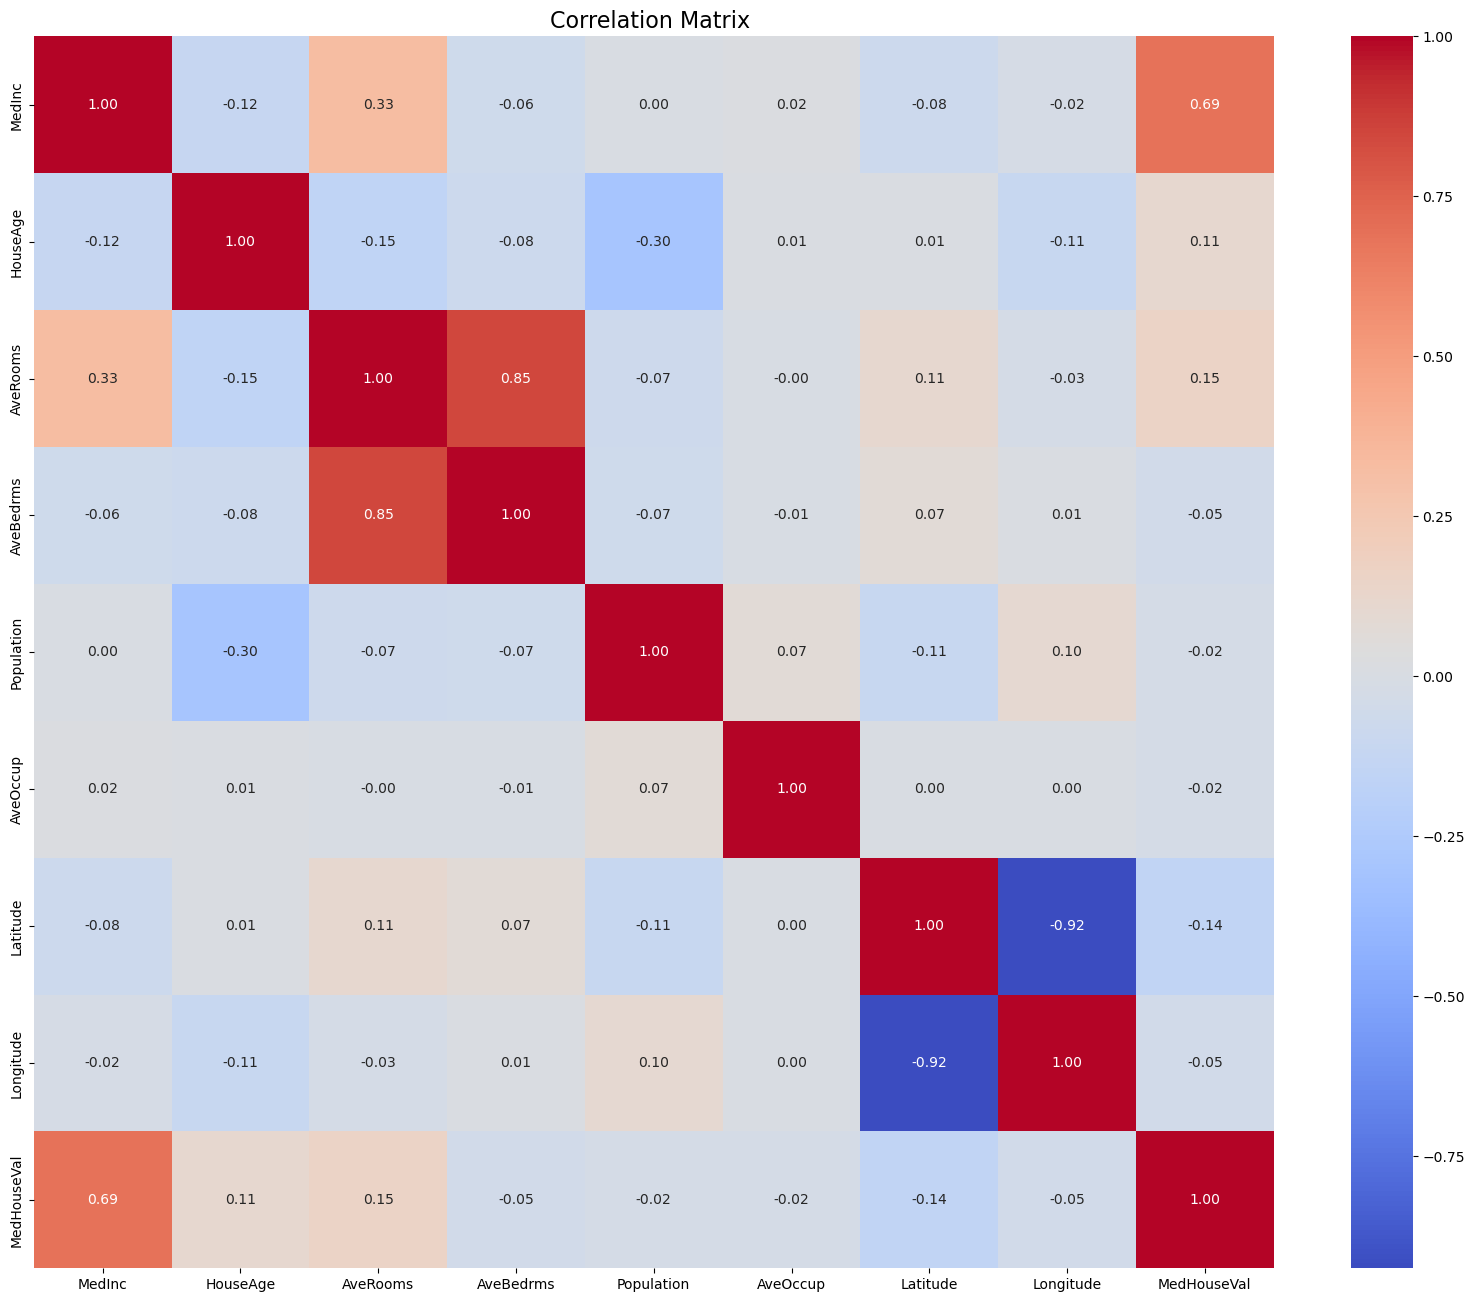


Correlation with Target (response)
MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64

Response Variable: MedHouseVal
Predictor Variables (8): ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Result of Linear Regression :
Estimated Coefficients :
Intercept : -37.0233
Coefficient for MedInc : 0.4487
Coefficient for HouseAge : 0.0097
Coefficient for AveRooms : -0.1233
Coefficient for AveBedrms : 0.7831
Coefficient for Population : -0.0000
Coefficient for AveOccup : -0.0035
Coefficient for Latitude : -0.4198
Coefficient for Longitude : -0.4337


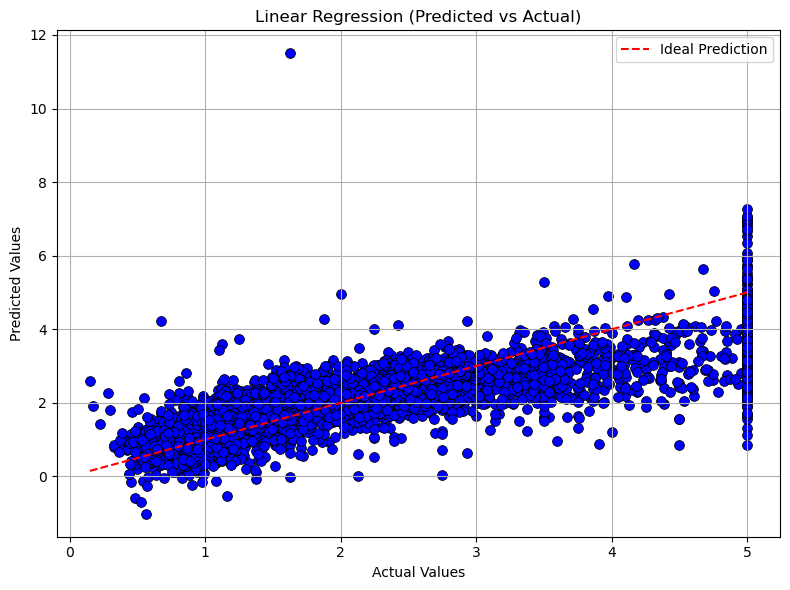

Train RSS : 8552.1118
Test RSS :2294.7205
Train MSE :0.5179
Test MSE :0.5559
Train R^2 :0.61
Test R^2 :0.58


Result of Ridge Regression :
Ridge Regression Coefficients:
Intercept (β₀): -36.7488
Coefficient for MedInc: 0.4484
Coefficient for HouseAge: 0.0098
Coefficient for AveRooms: -0.1226
Coefficient for AveBedrms: 0.7783
Coefficient for Population: -0.0000
Coefficient for AveOccup: -0.0035
Coefficient for Latitude: -0.4169
Coefficient for Longitude: -0.4305


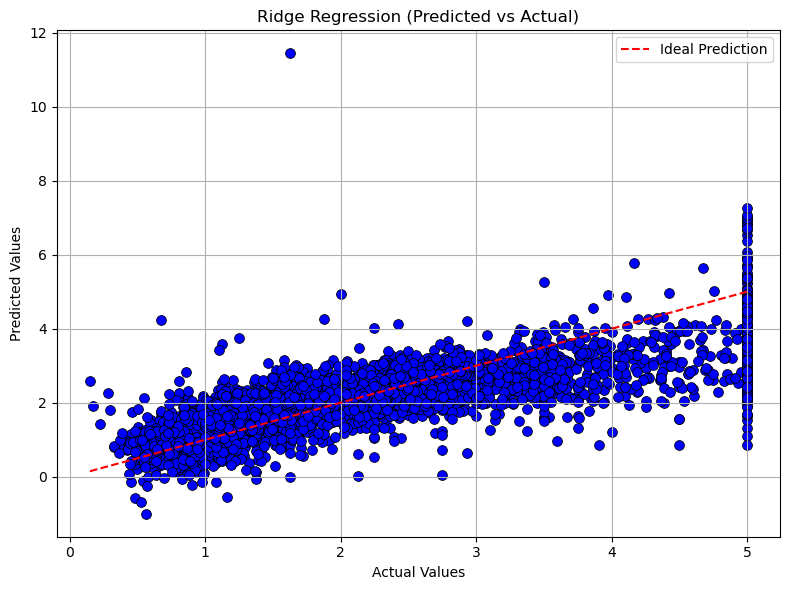

Train RSS : 8552.2159
Test RSS :2293.4935
Train MSE :0.5179
Test MSE :0.5556
Train R^2 :0.61
Test R^2 :0.58
Train Adjusted R^2 :0.61
Test Adjusted R^2 :0.58


Result of Lasso Regression :
Lasso Regression Coefficients:
Intercept (β₀): -36.4440
Coefficient for MedInc: 0.4457
Coefficient for HouseAge: 0.0098
Coefficient for AveRooms: -0.1173
Coefficient for AveBedrms: 0.7497
Coefficient for Population: -0.0000
Coefficient for AveOccup: -0.0034
Coefficient for Latitude: -0.4141
Coefficient for Longitude: -0.4273


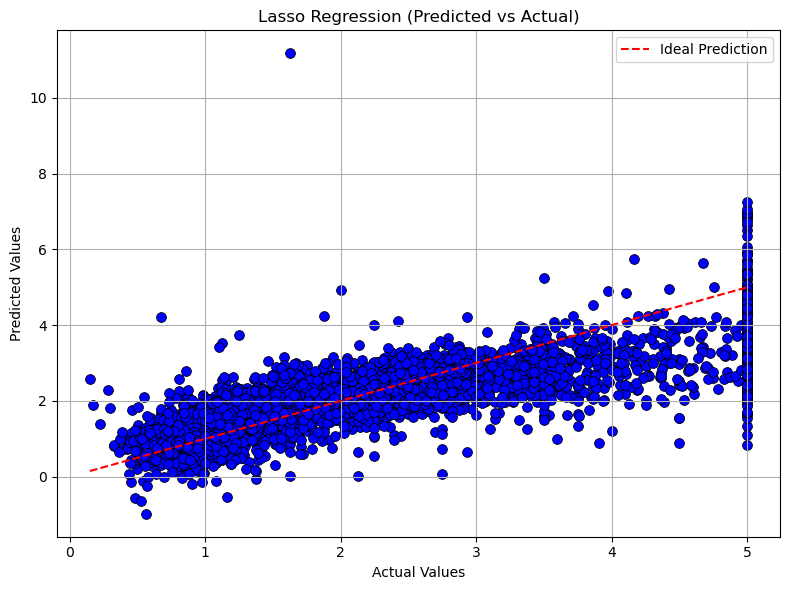

Train RSS : 8553.2250
Test RSS :2288.4103
Train MSE :0.5180
Test MSE :0.5544
Train R^2 :0.61
Test R^2 :0.58
Train Adjusted R^2 :0.61
Test Adjusted R^2 :0.58


Result of Regression Tree:
Final Regression Tree Evaluation
Best alpha (from CV): 3.5
Tree Depth: 5
Internal Nodes: 31
Number of Leaves: 32
Train RSS: 8038.58
Train MSE: 0.4868
Test RSS: 2200.85
Test MSE: 0.5332
Train R_2 Score: 0.6358
Test R_2 Score: 0.5931


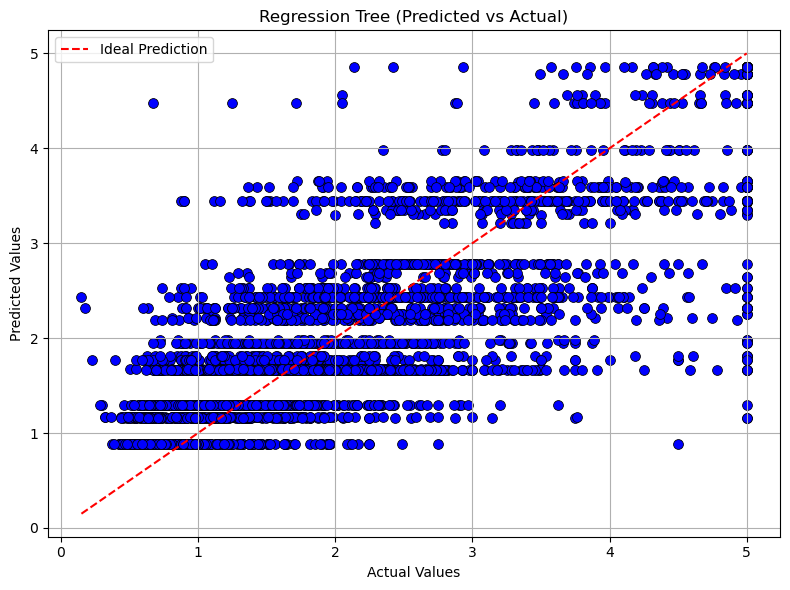



Result of Random Forest :


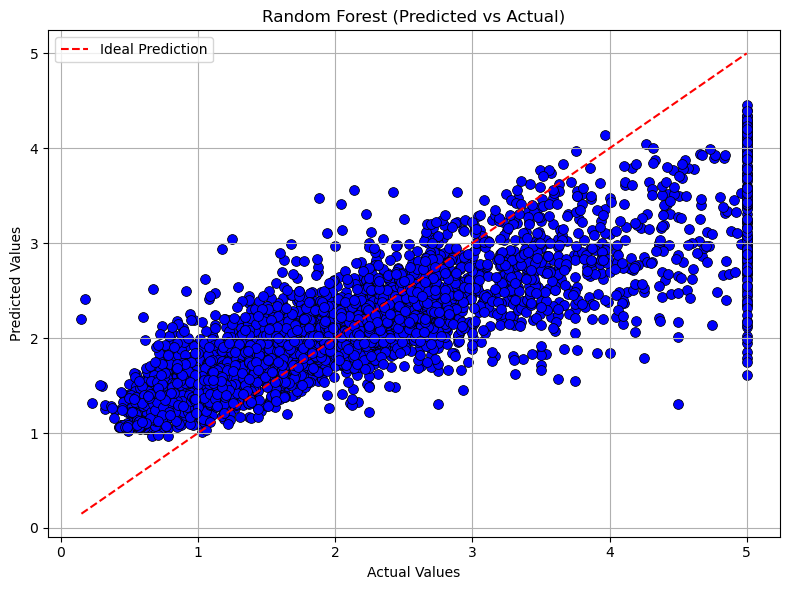

Random Forest Metric Evaluation
Train_RSS :7763.3459
Test_RSS :2001.6006
Train MSE :0.4702
Test MSE :0.4849
Train R^2: 0.6483
Test R^2: 0.6300


Result of XGBoost :


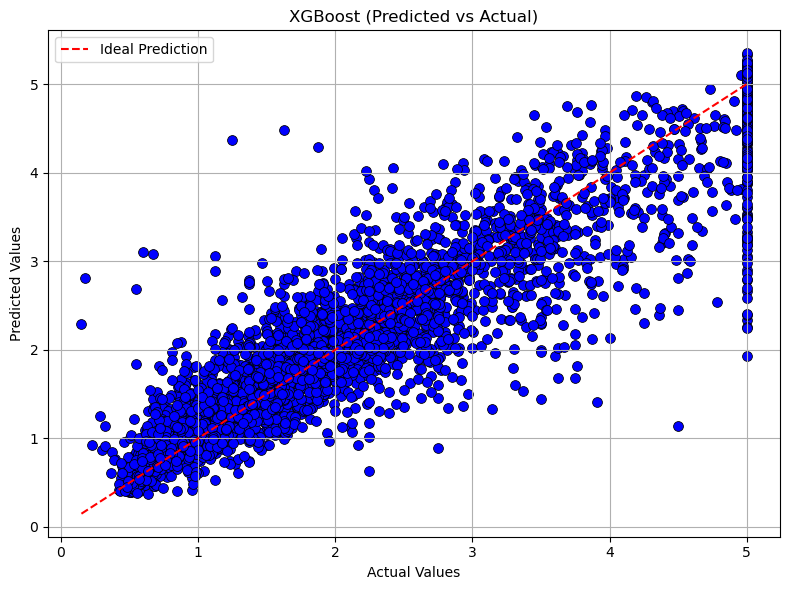

XGBoost Metric Evaluation 
Train_RSS :2953.7150
Test_RSS :992.3168
Train MSE :0.1789
Test MSE :0.2404
Train R^2: 0.8662
Test R^2: 0.8166


In [36]:
# Exploratory Data Analysis Predicting the data with all model
print("Result of Exploratory Data Analysis :")
EDA_processing(Housing,response)
print()
print("=" * 50)
print()
print("Result of Linear Regression :")
evaluate_linear_regression(x,y,predictors)
print()
print("=" * 50)
print()
print("Result of Ridge Regression :")
evaluate_ridge_regression(x,y,predictors)
print()
print("=" * 50)
print()
print("Result of Lasso Regression :")
evaluate_lasso_regression(x,y,predictors)
print()
print("=" * 50)
print()
print("Result of Regression Tree:")
evaluate_regression_tree(data,x)
print()
print("=" * 50)
print()
print("Result of Random Forest :")
evaluate_random_forest(data)
print()
print("=" * 50)
print()
print("Result of XGBoost :")
evaluate_XGBoost(data)




##  Model Performance Summary

Below is a summary of the performance of different regression models evaluated on the housing dataset. Metrics include training and testing errors as well as \( R^2 \) scores.

### Performance Comparison Table

| Model                | Train MSE | Test MSE | Train \( R^2 \) | Test \( R^2 \) |
|---------------------|-----------|----------|------------------|-----------------|
| **Linear Regression** | 0.5179    | 0.5559   | 0.6100           | 0.5800          |
| **Ridge Regression**  | 0.5179    | 0.5556   | 0.6100           | 0.5800          |
| **Lasso Regression**  | 0.5180    | 0.5544   | 0.6100           | 0.5800          |
| **Regression Tree**   | 0.4889    | 0.5303   | 0.6358           | 0.5931          |
| **Random Forest**     | 0.4702    | 0.4849   | 0.6483           | 0.6300          |
| **XGBoost**           | **0.1775**| **0.2391**| **0.8672**       | **0.8175**      |

### Explanation and Insights

- **Linear, Ridge, and Lasso Regression**:  
  These linear models yield very similar performance. Slight gains are observed with regularization (Ridge and Lasso), but the improvement is marginal. The \( R^2 \) score on the test set is around 0.58, suggesting that the model explains 58% of the variance in the data.

- **Regression Tree**:  
  The decision tree model performs moderately better than the linear models, with a test \( R^2 \) of 0.5954. The tree structure captures nonlinear interactions, though it may suffer from variance issues.

- **Random Forest**:  
  This ensemble method outperforms all previous models except XGBoost. It reduces variance via averaging and shows improved generalization with a test \( R^2 \) of 0.6300.

- **XGBoost**:  
  The best-performing model by a large margin. With a test \( R^2 \) of **0.8175**, it significantly outperforms other models in both accuracy and error reduction. XGBoost effectively captures complex, nonlinear patterns in the data, thanks to its boosting technique and regularization.

### Final Recommendation

> **XGBoost** is the recommended model for predicting housing prices based on its superior generalization performance, lower MSE, and highest \( R^2 \) score. It balances bias and variance effectively and is well-suited for this regression task.


# Final Conclusion :

In this project, various regression models were implemented and compared using the California Housing dataset. The models included Linear Regression, Ridge, Lasso, Regression Trees, Random Forest, and XGBoost. Each model was evaluated based on training and testing Mean Squared Error (MSE) and R² scores. 

Among all models, the linear models (Linear, Ridge, and Lasso) showed similar performance with R² values around 0.58 on the test set, indicating moderate predictive power. Regression Trees improved slightly over linear models, capturing some nonlinear relationships. Random Forest further improved performance by reducing variance through ensemble learning, achieving a test R² of 0.6066.

However, **XGBoost emerged as the most effective model**, significantly outperforming all others with a test R² of **0.8175** and the lowest test MSE. Its sequential boosting mechanism and ability to model complex patterns made it highly suitable for this regression task.

**Conclusion**:  
> **XGBoost is the most recommended model** for predicting housing prices in this context due to its strong generalization ability, low error metrics, and superior R² score.
